##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Data augmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/data_augmentation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This tutorial demonstrates data augmentation: a technique to increase the diversity of your training set by applying random (but realistic) transformations such as image rotation. You will learn how to apply data augmentation in two ways. First, you will use [Keras Preprocessing Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/). Next, you will use `tf.image`.

## Setup

In [2]:
!pip install -q tf-nightly

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Download a dataset

This tutorial uses the [tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) dataset. For convenience, download the dataset using [TensorFlow Datasets](https://www.tensorflow.org/datasets). If you would like to learn about others ways of importing data, see the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.


In [4]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dataset tf_flowers downloaded and prepared to /home/kbuilder/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


The flowers dataset has five classes.

In [5]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


Let's retrieve an image from the dataset and use it to demonstrate data augmentation.

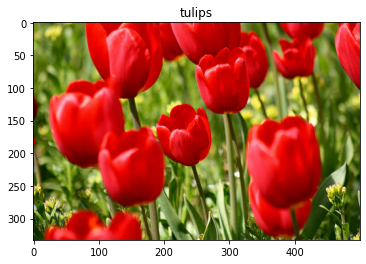

In [6]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Use Keras preprocessing layers

Note: The [Keras Preprocesing Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) introduced in this section are currently experimental.

### Resizing and rescaling


You can use preprocessing layers to [resize](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) your images to a consistent shape, and to [rescale](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) pixel values.

In [7]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

Note: the rescaling layer above standardizes pixel values to `[0,1]`. If instead you wanted `[-1,1]`, you would write `Rescaling(1./127.5, offset=-1)`.


You can see the result of applying these layers to an image. 

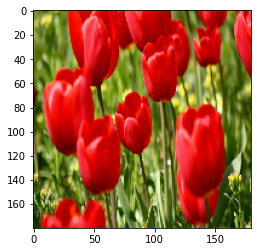

In [8]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

You can verify the pixels are in `[0-1]`.

In [9]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### Data augmentation

You can use preprocessing layers for data augmentation as well.

Let's create a few preprocessing layers and apply them repeatedly to the same image.

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

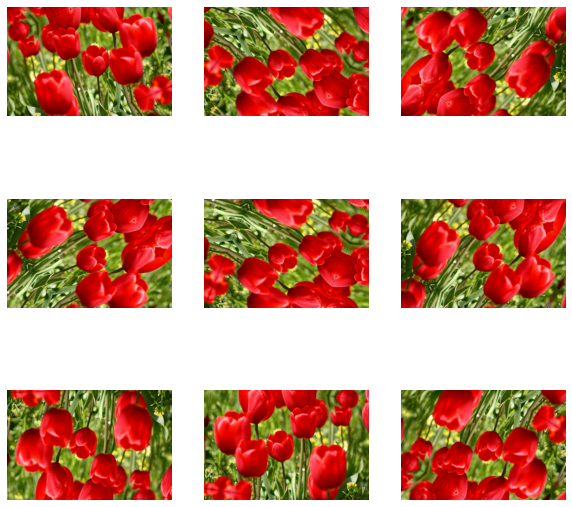

In [12]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

There are a variety of preprocessing [layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) you can use for data augmentation including `layers.RandomContrast`, `layers.RandomCrop`, `layers.RandomZoom`, and others.

### Two options to use the preprocessing layers

There are two ways you can use these preprocessing layers, with important tradeoffs.

#### Option 1: Make the preprocessing layers part of your model

In [13]:
model = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model
])

There are two important points to be aware of in this case:

* Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.

* When you export your model using `model.save`, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.

Note: Data augmentation is inactive at test time so input images will only be augmented during calls to `model.fit` (not `model.evaluate` or `model.predict`).

#### Option 2: Apply the preprocessing layers to your dataset

In [14]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

With this approach, you use `Dataset.map` to create a dataset that yields batches of augmented images. In this case:

* Data augmentation will happen asynchronously on the CPU, and is non-blocking. You can overlap the training of your model on the GPU with data preprocessing, using `Dataset.prefetch`, shown below.
* In this case the prepreprocessing layers will not be exported with the model when you call `model.save`. You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export.


You can find an example of the first option in the [image classification](https://www.tensorflow.org/tutorials/images/classification) tutorial. Let's demonstrate the second option here.

### Apply the preprocessing layers to the datasets

Configure the train, validation, and test datasets with the preprocessing layers you created above. You will also configure the datasets for performance, using parallel reads and buffered prefetching to yield batches from disk without I/O become blocking. You can learn more dataset performance in the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) guide. 

Note: data augmentation should only be applied to the training set.

In [15]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### Train a model

For completeness, you will now train a model using these datasets. This model has not been tuned for accuracy (the goal is to show you the mechanics).

In [17]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


 1/92 [..............................] - ETA: 4:36 - loss: 1.6000 - accuracy: 0.3125

 6/92 [>.............................] - ETA: 44s - loss: 2.4085 - accuracy: 0.2300 

10/92 [==>...........................] - ETA: 25s - loss: 2.3161 - accuracy: 0.2127

13/92 [===>..........................] - ETA: 19s - loss: 2.2446 - accuracy: 0.2096

14/92 [===>..........................] - ETA: 18s - loss: 2.2233 - accuracy: 0.2096

15/92 [===>..........................] - ETA: 17s - loss: 2.2033 - accuracy: 0.2091

16/92 [====>.........................] - ETA: 16s - loss: 2.1846 - accuracy: 0.2084

17/92 [====>.........................] - ETA: 15s - loss: 2.1671 - accuracy: 0.2077

18/92 [====>.........................] - ETA: 14s - loss: 2.1505 - accuracy: 0.2073

19/92 [=====>........................] - ETA: 13s - loss: 2.1350 - accuracy: 0.2074

20/92 [=====>........................] - ETA: 13s - loss: 2.1203 - accuracy: 0.2076

21/92 [=====>........................] - ETA: 12s - loss: 2.1064 - accuracy: 0.2081

22/92 [======>.......................] - ETA: 11s - loss: 2.0934 - accuracy: 0.2084

23/92 [======>.......................] - ETA: 11s - loss: 2.0810 - accuracy: 0.2086

24/92 [======>.......................] - ETA: 10s - loss: 2.0693 - accuracy: 0.2087

25/92 [=======>......................] - ETA: 10s - loss: 2.0581 - accuracy: 0.2088

26/92 [=======>......................] - ETA: 10s - loss: 2.0475 - accuracy: 0.2091

27/92 [=======>......................] - ETA: 9s - loss: 2.0373 - accuracy: 0.2095 

28/92 [========>.....................] - ETA: 9s - loss: 2.0275 - accuracy: 0.2098

29/92 [========>.....................] - ETA: 8s - loss: 2.0183 - accuracy: 0.2102

30/92 [========>.....................] - ETA: 8s - loss: 2.0093 - accuracy: 0.2107

31/92 [=========>....................] - ETA: 8s - loss: 2.0008 - accuracy: 0.2112

33/92 [=========>....................] - ETA: 7s - loss: 1.9847 - accuracy: 0.2124

34/92 [==========>...................] - ETA: 7s - loss: 1.9770 - accuracy: 0.2131

35/92 [==========>...................] - ETA: 7s - loss: 1.9695 - accuracy: 0.2139

37/92 [===========>..................] - ETA: 6s - loss: 1.9557 - accuracy: 0.2152

38/92 [===========>..................] - ETA: 6s - loss: 1.9490 - accuracy: 0.2160

40/92 [============>.................] - ETA: 6s - loss: 1.9365 - accuracy: 0.2178

41/92 [============>.................] - ETA: 5s - loss: 1.9306 - accuracy: 0.2186

43/92 [=============>................] - ETA: 5s - loss: 1.9192 - accuracy: 0.2204

44/92 [=============>................] - ETA: 5s - loss: 1.9138 - accuracy: 0.2213

46/92 [==============>...............] - ETA: 5s - loss: 1.9037 - accuracy: 0.2229

47/92 [==============>...............] - ETA: 4s - loss: 1.8988 - accuracy: 0.2237

49/92 [==============>...............] - ETA: 4s - loss: 1.8895 - accuracy: 0.2252

50/92 [===============>..............] - ETA: 4s - loss: 1.8849 - accuracy: 0.2260

51/92 [===============>..............] - ETA: 4s - loss: 1.8805 - accuracy: 0.2269

52/92 [===============>..............] - ETA: 4s - loss: 1.8761 - accuracy: 0.2278

53/92 [================>.............] - ETA: 4s - loss: 1.8718 - accuracy: 0.2286

54/92 [================>.............] - ETA: 3s - loss: 1.8677 - accuracy: 0.2295

55/92 [================>.............] - ETA: 3s - loss: 1.8636 - accuracy: 0.2303

56/92 [=================>............] - ETA: 3s - loss: 1.8596 - accuracy: 0.2311

57/92 [=================>............] - ETA: 3s - loss: 1.8556 - accuracy: 0.2319

58/92 [=================>............] - ETA: 3s - loss: 1.8517 - accuracy: 0.2328

59/92 [==================>...........] - ETA: 3s - loss: 1.8478 - accuracy: 0.2337

60/92 [==================>...........] - ETA: 3s - loss: 1.8439 - accuracy: 0.2346

61/92 [==================>...........] - ETA: 3s - loss: 1.8401 - accuracy: 0.2354

66/92 [====================>.........] - ETA: 2s - loss: 1.8218 - accuracy: 0.2396

67/92 [====================>.........] - ETA: 2s - loss: 1.8182 - accuracy: 0.2404

69/92 [=====================>........] - ETA: 2s - loss: 1.8113 - accuracy: 0.2421

72/92 [======================>.......] - ETA: 1s - loss: 1.8013 - accuracy: 0.2447

74/92 [=======================>......] - ETA: 1s - loss: 1.7949 - accuracy: 0.2464

77/92 [========================>.....] - ETA: 1s - loss: 1.7856 - accuracy: 0.2489

78/92 [========================>.....] - ETA: 1s - loss: 1.7826 - accuracy: 0.2497

81/92 [=========================>....] - ETA: 0s - loss: 1.7737 - accuracy: 0.2522

84/92 [==========================>...] - ETA: 0s - loss: 1.7652 - accuracy: 0.2545

86/92 [===========================>..] - ETA: 0s - loss: 1.7597 - accuracy: 0.2562

89/92 [============================>.] - ETA: 0s - loss: 1.7516 - accuracy: 0.2585

91/92 [============================>.] - ETA: 0s - loss: 1.7463 - accuracy: 0.2600

92/92 [==============================] - ETA: 0s - loss: 1.7437 - accuracy: 0.2608

92/92 [==============================] - 7s 79ms/step - loss: 1.7411 - accuracy: 0.2616 - val_loss: 1.3436 - val_accuracy: 0.4496


Epoch 2/5


 1/92 [..............................] - ETA: 17s - loss: 1.1955 - accuracy: 0.4375

 2/92 [..............................] - ETA: 11s - loss: 1.2243 - accuracy: 0.4375

 4/92 [>.............................] - ETA: 7s - loss: 1.2353 - accuracy: 0.4811 

 5/92 [>.............................] - ETA: 7s - loss: 1.2530 - accuracy: 0.4974

 8/92 [=>............................] - ETA: 5s - loss: 1.2772 - accuracy: 0.5120

10/92 [==>...........................] - ETA: 4s - loss: 1.2847 - accuracy: 0.5119

13/92 [===>..........................] - ETA: 4s - loss: 1.2865 - accuracy: 0.5106

16/92 [====>.........................] - ETA: 3s - loss: 1.2864 - accuracy: 0.5074

18/92 [====>.........................] - ETA: 3s - loss: 1.2859 - accuracy: 0.5052

21/92 [=====>........................] - ETA: 3s - loss: 1.2825 - accuracy: 0.5038

24/92 [======>.......................] - ETA: 2s - loss: 1.2805 - accuracy: 0.5017

27/92 [=======>......................] - ETA: 2s - loss: 1.2782 - accuracy: 0.5008

30/92 [========>.....................] - ETA: 2s - loss: 1.2760 - accuracy: 0.4999

31/92 [=========>....................] - ETA: 2s - loss: 1.2755 - accuracy: 0.4995

35/92 [==========>...................] - ETA: 2s - loss: 1.2734 - accuracy: 0.4978

37/92 [===========>..................] - ETA: 2s - loss: 1.2722 - accuracy: 0.4971

38/92 [===========>..................] - ETA: 2s - loss: 1.2717 - accuracy: 0.4967

41/92 [============>.................] - ETA: 1s - loss: 1.2702 - accuracy: 0.4955

43/92 [=============>................] - ETA: 1s - loss: 1.2689 - accuracy: 0.4950

45/92 [=============>................] - ETA: 1s - loss: 1.2676 - accuracy: 0.4947

46/92 [==============>...............] - ETA: 1s - loss: 1.2672 - accuracy: 0.4945

49/92 [==============>...............] - ETA: 1s - loss: 1.2658 - accuracy: 0.4941

50/92 [===============>..............] - ETA: 1s - loss: 1.2652 - accuracy: 0.4940

53/92 [================>.............] - ETA: 1s - loss: 1.2633 - accuracy: 0.4939

54/92 [================>.............] - ETA: 1s - loss: 1.2627 - accuracy: 0.4939

56/92 [=================>............] - ETA: 1s - loss: 1.2615 - accuracy: 0.4938

57/92 [=================>............] - ETA: 1s - loss: 1.2609 - accuracy: 0.4937

59/92 [==================>...........] - ETA: 1s - loss: 1.2595 - accuracy: 0.4936

62/92 [===================>..........] - ETA: 1s - loss: 1.2576 - accuracy: 0.4936

65/92 [====================>.........] - ETA: 0s - loss: 1.2556 - accuracy: 0.4936

67/92 [====================>.........] - ETA: 0s - loss: 1.2543 - accuracy: 0.4937

70/92 [=====================>........] - ETA: 0s - loss: 1.2523 - accuracy: 0.4940

73/92 [======================>.......] - ETA: 0s - loss: 1.2501 - accuracy: 0.4943

75/92 [=======================>......] - ETA: 0s - loss: 1.2486 - accuracy: 0.4946

79/92 [========================>.....] - ETA: 0s - loss: 1.2457 - accuracy: 0.4951

85/92 [==========================>...] - ETA: 0s - loss: 1.2414 - accuracy: 0.4960

89/92 [============================>.] - ETA: 0s - loss: 1.2388 - accuracy: 0.4965

92/92 [==============================] - 3s 33ms/step - loss: 1.2362 - accuracy: 0.4972 - val_loss: 1.0550 - val_accuracy: 0.6376


Epoch 3/5


 1/92 [..............................] - ETA: 17s - loss: 1.1511 - accuracy: 0.5938

 2/92 [..............................] - ETA: 12s - loss: 1.1557 - accuracy: 0.5703

 4/92 [>.............................] - ETA: 7s - loss: 1.1701 - accuracy: 0.5645 

 7/92 [=>............................] - ETA: 5s - loss: 1.1577 - accuracy: 0.5705

 8/92 [=>............................] - ETA: 5s - loss: 1.1510 - accuracy: 0.5720

11/92 [==>...........................] - ETA: 4s - loss: 1.1391 - accuracy: 0.5690

14/92 [===>..........................] - ETA: 3s - loss: 1.1293 - accuracy: 0.5684

16/92 [====>.........................] - ETA: 3s - loss: 1.1245 - accuracy: 0.5678

18/92 [====>.........................] - ETA: 3s - loss: 1.1214 - accuracy: 0.5670

22/92 [======>.......................] - ETA: 2s - loss: 1.1156 - accuracy: 0.5669

24/92 [======>.......................] - ETA: 2s - loss: 1.1142 - accuracy: 0.5670

26/92 [=======>......................] - ETA: 2s - loss: 1.1132 - accuracy: 0.5672

29/92 [========>.....................] - ETA: 2s - loss: 1.1111 - accuracy: 0.5680

33/92 [=========>....................] - ETA: 2s - loss: 1.1083 - accuracy: 0.5689

36/92 [==========>...................] - ETA: 2s - loss: 1.1072 - accuracy: 0.5693

39/92 [===========>..................] - ETA: 1s - loss: 1.1070 - accuracy: 0.5691

41/92 [============>.................] - ETA: 1s - loss: 1.1069 - accuracy: 0.5690

43/92 [=============>................] - ETA: 1s - loss: 1.1064 - accuracy: 0.5689

46/92 [==============>...............] - ETA: 1s - loss: 1.1060 - accuracy: 0.5685

48/92 [==============>...............] - ETA: 1s - loss: 1.1059 - accuracy: 0.5680

51/92 [===============>..............] - ETA: 1s - loss: 1.1059 - accuracy: 0.5673

53/92 [================>.............] - ETA: 1s - loss: 1.1061 - accuracy: 0.5668

55/92 [================>.............] - ETA: 1s - loss: 1.1062 - accuracy: 0.5665

56/92 [=================>............] - ETA: 1s - loss: 1.1062 - accuracy: 0.5664

57/92 [=================>............] - ETA: 1s - loss: 1.1061 - accuracy: 0.5663

59/92 [==================>...........] - ETA: 1s - loss: 1.1059 - accuracy: 0.5661

60/92 [==================>...........] - ETA: 1s - loss: 1.1059 - accuracy: 0.5660

63/92 [===================>..........] - ETA: 1s - loss: 1.1055 - accuracy: 0.5658

65/92 [====================>.........] - ETA: 0s - loss: 1.1052 - accuracy: 0.5656

68/92 [=====================>........] - ETA: 0s - loss: 1.1047 - accuracy: 0.5655

70/92 [=====================>........] - ETA: 0s - loss: 1.1043 - accuracy: 0.5654

74/92 [=======================>......] - ETA: 0s - loss: 1.1032 - accuracy: 0.5654

76/92 [=======================>......] - ETA: 0s - loss: 1.1027 - accuracy: 0.5653

79/92 [========================>.....] - ETA: 0s - loss: 1.1020 - accuracy: 0.5652

83/92 [==========================>...] - ETA: 0s - loss: 1.1010 - accuracy: 0.5651

89/92 [============================>.] - ETA: 0s - loss: 1.0996 - accuracy: 0.5650

92/92 [==============================] - 3s 32ms/step - loss: 1.0987 - accuracy: 0.5650 - val_loss: 0.9925 - val_accuracy: 0.6512


Epoch 4/5


 1/92 [..............................] - ETA: 17s - loss: 0.9003 - accuracy: 0.7188

 2/92 [..............................] - ETA: 14s - loss: 0.9252 - accuracy: 0.7031

 5/92 [>.............................] - ETA: 7s - loss: 1.0264 - accuracy: 0.6422 

 9/92 [=>............................] - ETA: 4s - loss: 1.0580 - accuracy: 0.6121

11/92 [==>...........................] - ETA: 4s - loss: 1.0624 - accuracy: 0.6050

13/92 [===>..........................] - ETA: 3s - loss: 1.0643 - accuracy: 0.6006

15/92 [===>..........................] - ETA: 3s - loss: 1.0670 - accuracy: 0.5964

16/92 [====>.........................] - ETA: 3s - loss: 1.0678 - accuracy: 0.5945

20/92 [=====>........................] - ETA: 3s - loss: 1.0705 - accuracy: 0.5893

23/92 [======>.......................] - ETA: 2s - loss: 1.0711 - accuracy: 0.5868

26/92 [=======>......................] - ETA: 2s - loss: 1.0710 - accuracy: 0.5851

29/92 [========>.....................] - ETA: 2s - loss: 1.0706 - accuracy: 0.5836

32/92 [=========>....................] - ETA: 2s - loss: 1.0706 - accuracy: 0.5823

36/92 [==========>...................] - ETA: 2s - loss: 1.0694 - accuracy: 0.5816

37/92 [===========>..................] - ETA: 2s - loss: 1.0693 - accuracy: 0.5815

40/92 [============>.................] - ETA: 1s - loss: 1.0685 - accuracy: 0.5813

42/92 [============>.................] - ETA: 1s - loss: 1.0682 - accuracy: 0.5811

45/92 [=============>................] - ETA: 1s - loss: 1.0672 - accuracy: 0.5812

47/92 [==============>...............] - ETA: 1s - loss: 1.0662 - accuracy: 0.5815

48/92 [==============>...............] - ETA: 1s - loss: 1.0657 - accuracy: 0.5817

51/92 [===============>..............] - ETA: 1s - loss: 1.0640 - accuracy: 0.5820

52/92 [===============>..............] - ETA: 1s - loss: 1.0635 - accuracy: 0.5822

55/92 [================>.............] - ETA: 1s - loss: 1.0620 - accuracy: 0.5826

57/92 [=================>............] - ETA: 1s - loss: 1.0613 - accuracy: 0.5827

60/92 [==================>...........] - ETA: 1s - loss: 1.0605 - accuracy: 0.5830

63/92 [===================>..........] - ETA: 1s - loss: 1.0595 - accuracy: 0.5834

65/92 [====================>.........] - ETA: 0s - loss: 1.0587 - accuracy: 0.5837

66/92 [====================>.........] - ETA: 0s - loss: 1.0583 - accuracy: 0.5839

69/92 [=====================>........] - ETA: 0s - loss: 1.0570 - accuracy: 0.5845

71/92 [======================>.......] - ETA: 0s - loss: 1.0560 - accuracy: 0.5849

74/92 [=======================>......] - ETA: 0s - loss: 1.0546 - accuracy: 0.5856

76/92 [=======================>......] - ETA: 0s - loss: 1.0536 - accuracy: 0.5861

78/92 [========================>.....] - ETA: 0s - loss: 1.0526 - accuracy: 0.5865

80/92 [=========================>....] - ETA: 0s - loss: 1.0515 - accuracy: 0.5870

84/92 [==========================>...] - ETA: 0s - loss: 1.0492 - accuracy: 0.5880

88/92 [===========================>..] - ETA: 0s - loss: 1.0472 - accuracy: 0.5889

90/92 [============================>.] - ETA: 0s - loss: 1.0461 - accuracy: 0.5894

92/92 [==============================] - 3s 33ms/step - loss: 1.0445 - accuracy: 0.5902 - val_loss: 0.9479 - val_accuracy: 0.6567


Epoch 5/5


 1/92 [..............................] - ETA: 19s - loss: 0.7701 - accuracy: 0.7188

 2/92 [..............................] - ETA: 13s - loss: 0.8485 - accuracy: 0.6953

 5/92 [>.............................] - ETA: 6s - loss: 0.9314 - accuracy: 0.6569 

 7/92 [=>............................] - ETA: 5s - loss: 0.9555 - accuracy: 0.6487

 9/92 [=>............................] - ETA: 4s - loss: 0.9587 - accuracy: 0.6482

12/92 [==>...........................] - ETA: 3s - loss: 0.9654 - accuracy: 0.6449

13/92 [===>..........................] - ETA: 3s - loss: 0.9670 - accuracy: 0.6432

15/92 [===>..........................] - ETA: 3s - loss: 0.9687 - accuracy: 0.6407

17/92 [====>.........................] - ETA: 3s - loss: 0.9717 - accuracy: 0.6381

20/92 [=====>........................] - ETA: 2s - loss: 0.9747 - accuracy: 0.6361

22/92 [======>.......................] - ETA: 2s - loss: 0.9742 - accuracy: 0.6354

24/92 [======>.......................] - ETA: 2s - loss: 0.9724 - accuracy: 0.6361

28/92 [========>.....................] - ETA: 2s - loss: 0.9676 - accuracy: 0.6384

30/92 [========>.....................] - ETA: 2s - loss: 0.9659 - accuracy: 0.6391

33/92 [=========>....................] - ETA: 2s - loss: 0.9631 - accuracy: 0.6401

35/92 [==========>...................] - ETA: 2s - loss: 0.9614 - accuracy: 0.6406

36/92 [==========>...................] - ETA: 2s - loss: 0.9605 - accuracy: 0.6409

40/92 [============>.................] - ETA: 1s - loss: 0.9576 - accuracy: 0.6412

43/92 [=============>................] - ETA: 1s - loss: 0.9570 - accuracy: 0.6408

45/92 [=============>................] - ETA: 1s - loss: 0.9570 - accuracy: 0.6404

48/92 [==============>...............] - ETA: 1s - loss: 0.9567 - accuracy: 0.6399

50/92 [===============>..............] - ETA: 1s - loss: 0.9562 - accuracy: 0.6397

51/92 [===============>..............] - ETA: 1s - loss: 0.9558 - accuracy: 0.6397

53/92 [================>.............] - ETA: 1s - loss: 0.9552 - accuracy: 0.6395

54/92 [================>.............] - ETA: 1s - loss: 0.9550 - accuracy: 0.6395

57/92 [=================>............] - ETA: 1s - loss: 0.9544 - accuracy: 0.6394

59/92 [==================>...........] - ETA: 1s - loss: 0.9541 - accuracy: 0.6394

60/92 [==================>...........] - ETA: 1s - loss: 0.9541 - accuracy: 0.6393

63/92 [===================>..........] - ETA: 1s - loss: 0.9537 - accuracy: 0.6392

65/92 [====================>.........] - ETA: 0s - loss: 0.9535 - accuracy: 0.6391

68/92 [=====================>........] - ETA: 0s - loss: 0.9531 - accuracy: 0.6390

70/92 [=====================>........] - ETA: 0s - loss: 0.9530 - accuracy: 0.6389

72/92 [======================>.......] - ETA: 0s - loss: 0.9529 - accuracy: 0.6387

74/92 [=======================>......] - ETA: 0s - loss: 0.9526 - accuracy: 0.6386

77/92 [========================>.....] - ETA: 0s - loss: 0.9524 - accuracy: 0.6383

79/92 [========================>.....] - ETA: 0s - loss: 0.9523 - accuracy: 0.6381

84/92 [==========================>...] - ETA: 0s - loss: 0.9519 - accuracy: 0.6376

90/92 [============================>.] - ETA: 0s - loss: 0.9513 - accuracy: 0.6371

92/92 [==============================] - 3s 33ms/step - loss: 0.9510 - accuracy: 0.6369 - val_loss: 0.9246 - val_accuracy: 0.6540


In [20]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

 1/12 [=>............................] - ETA: 1s - loss: 0.7844 - accuracy: 0.6875

 5/12 [===========>..................] - ETA: 0s - loss: 0.8751 - accuracy: 0.6125

 9/12 [=====================>........] - ETA: 0s - loss: 0.9021 - accuracy: 0.6250

12/12 [==============================] - 0s 28ms/step - loss: 0.8815 - accuracy: 0.6458


Accuracy 0.6457765698432922


### Custom data augmentation

You can also create custom data augmenation layers. This tutorial shows two ways of doing so. First, you will create a `layers.Lambda` layer. This is a good way to write concise code. Next, you will write a new layer via [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models), which gives you more control. Both layers will randomly invert the colors in an image, accoring to some probability. 

In [21]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [22]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

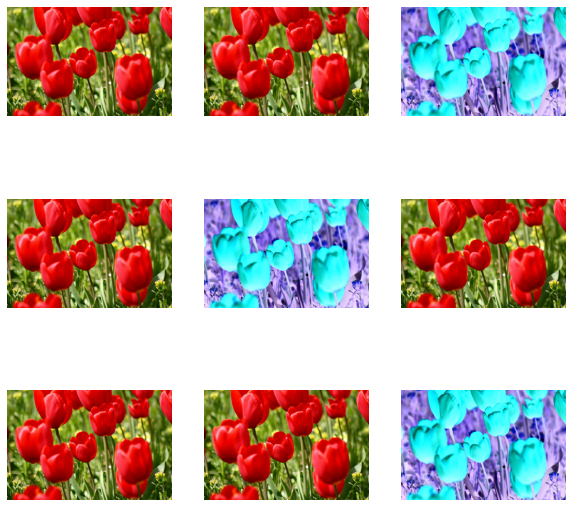

In [23]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

Next, implement a custom layer by [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models).

In [24]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

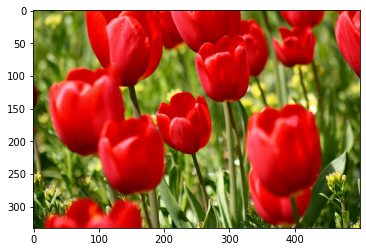

In [25]:
_ = plt.imshow(RandomInvert()(image)[0])

Both of these layers can be used as described in options 1 and 2 above.

## Using tf.image

The above `layers.preprocessing` utilities are convenient. For finer control, you can write your own data augmentation pipelines or layers using `tf.data` and `tf.image`. You may also want to check out [TensorFlow Addons Image: Operations](https://www.tensorflow.org/addons/tutorials/image_ops) and [TensorFlow I/O: Color Space Conversions](https://www.tensorflow.org/io/tutorials/colorspace)

Since the flowers dataset was previously configured with data augmentation, let's reimport it to start fresh.

In [26]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Retrieve an image to work with.

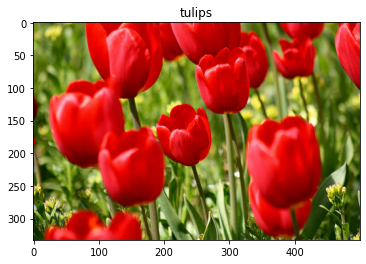

In [27]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

Let's use the following function to visualize and compare the original and augmented images side-by-side.

In [28]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

### Data augmentation

### Flipping the image

Flip the image either vertically or horizontally.

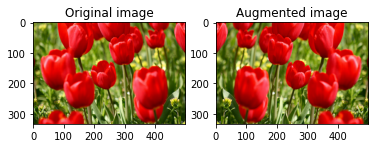

In [29]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

### Grayscale the image

Grayscale an image.

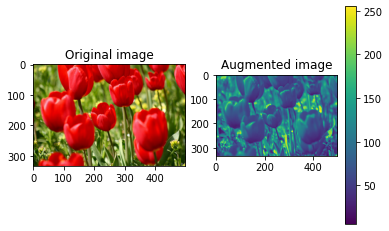

In [30]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

### Saturate the image

Saturate an image by providing a saturation factor.

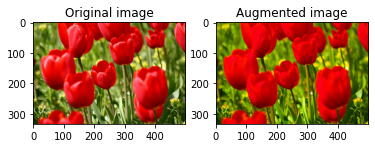

In [31]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

### Change image brightness

Change the brightness of image by providing a brightness factor.

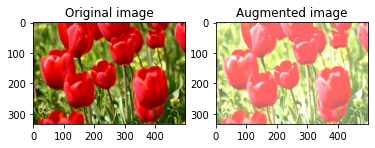

In [32]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

### Center crop the image

Crop the image from center up to the image part you desire.

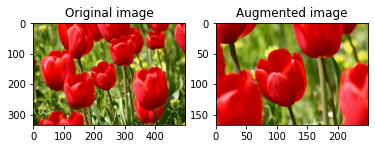

In [33]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

### Rotate the image

Rotate an image by 90 degrees.

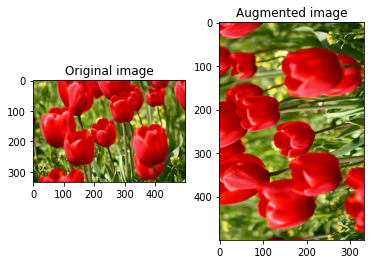

In [34]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

### Apply augmentation to a dataset

As before, apply data augmentation to a dataset using `Dataset.map`.

In [35]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

In [36]:
def augment(image,label):
  image, label = resize_and_rescale(image, label)
  # Add 6 pixels of padding
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6) 
   # Random crop back to the original size
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.clip_by_value(image, 0, 1)
  return image, label

### Configure the datasets

In [37]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
) 

In [38]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [39]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

These datasets can now be used to train a model as shown previously.

## Next steps

This tutorial demonstrated data augmentation using [Keras Preprocessing Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/) and `tf.image`. To learn how to include preprocessing layers inside your model, see the [Image classification](https://www.tensorflow.org/tutorials/images/classification) tutorial. You may also be interested in learning how preprocessing layers can help you classify text, as shown in the [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) tutorial. You can learn more about `tf.data` in this [guide](https://www.tensorflow.org/guide/data), and you can learn how to configure your input pipelines for performance [here](https://www.tensorflow.org/guide/data_performance).